# CS542 - Class Challenge - fine-grained classification of plants:

Our class challenge will consists of two tasks addressing an image recognition task where our dataset contains about 1K categories of plants with only about 250,000 images.  There will be two parts to this task:

1. Image classification. Imagine we have cateloged all the plants we care to identify, now we just need to create a classifier for them! Use your skills from the supervised learning sections of this course to try to address this problem.

2. Semi-Supervised/Few-Shot Learning.  Unfortunately, we missed some important plants we want to classify!  We do have some images we think contain the plant, but we have only have a few labels.  Our new goal is to develop an AI model that can learn from just these labeled examples.

Each student must submit a model on both tasks.  Students in the top 3 on each task will get 5% extra credit on this assignment.

This notebook is associated with the second task (semi-supervised).


# Dataset
The dataset is downloaded on scc in the address: "/projectnb2/cs542-bap/classChallenge/data". You can find the python version of this notebook there as well or you could just type "jupyter nbconvert --to script baselineModel_task2.ipynb" and it will output "baselineModel_task2.py". You should be able to run "baselineModel_task2.py" on scc by simply typing "python baselineModel_task2.py"

Please don't try to change or delete the dataset.

# Evaluation:
You will compete with each other over your performance on the dedicated test set. The performance measure is classification accuracy, i.e: if the true class is your top predictions. 

# Baseline:
The following code is a baseline which you can use and improve to come up with your model for this task

# Suggestion
One simple suggestion would be to use a pretrained model on imagenet and finetune it on this data similar to this [link](https://keras.io/api/applications/)
Also you should likely train more than 2 epochs.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create a dataset

In [2]:
data_dir = '/projectnb2/cs542-bap/class_challenge/'

train_samps = np.loadtxt(os.path.join(data_dir, 'train_held_out_labeled.txt'), dtype='str', delimiter=" ")
val_samps = np.loadtxt(os.path.join(data_dir, 'val_held_out.txt'), dtype='str', delimiter=" ")

train_len = len(train_samps)
val_len = len(val_samps)

samples = np.concatenate((train_samps, val_samps))

unlabeled_samps = np.loadtxt(os.path.join(data_dir, 'train_held_out.txt'), dtype='str')
unlabeled_len = len(unlabeled_samps)

test_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'test_held_out.txt'))

with open(os.path.join(data_dir, 'classes_held_out.txt'), 'r') as f:
    class_names = [c.strip() for c in f.readlines()]

num_classes = len(class_names)

## Write a short function that converts a file path to an (img, label) pair:

In [3]:
def decode_img(img, test=False, crop_size=224):
    img = tf.io.read_file(img)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)

    return tf.image.resize(img, [crop_size, crop_size])
  
def get_label(label):
    # find teh matching label
    one_hot = tf.where(tf.equal(label, class_names))
    # Integer encode the label
    return tf.reduce_min(one_hot)

def process_path(path, label):
    # should have two parts
    # file_path = tf.strings.split(file_path)
    # second part has the class index
    label = get_label(label)
   # load the raw data from the file
    img = decode_img(tf.strings.join([data_dir, 'images/', path, '.jpg']))
    return img, label

def process_path_test(file_path):
    # load the raw data from the file
    img = decode_img(tf.strings.join([data_dir, 'images/', file_path, '.jpg']))
    return img, file_path

# Finish setting up data

In [8]:
batch_size = 25

AUTOTUNE = tf.data.experimental.AUTOTUNE
test_ds = test_ds.map(process_path_test, num_parallel_calls=AUTOTUNE)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def shuffle_train_val(train_perc = 0.15):
    """
    This function returns shuffled train data and val data
    The default is we take 20% samples as training data
    """
    # define the train length
    train_len = int(train_perc*len(samples))
    
    # idexing train set and val set by random choice
    train_idx = np.random.choice(range(len(samples)), train_len, replace=True)
    val_idx = [idx for idx in range(len(samples)) if idx not in train_idx]
    
    # get train_ds and val_ds based on indexes
    train_ds = tf.data.Dataset.from_tensor_slices((samples[train_idx, 0], samples[train_idx, 1]))
    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds)
    val_ds = tf.data.Dataset.from_tensor_slices((samples[val_idx, 0], samples[val_idx, 1]))
    val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = configure_for_performance(val_ds)

    return train_ds, val_ds

TypeError: in user code:


    TypeError: tf__process_path_test() takes 1 positional argument but 2 were given


## Models

## ResNet50

In [5]:
class ResNet50(tf.keras.Model):

    def __init__(self):
        super(ResNet50, self).__init__()
        self.ResNet50 = keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        
        # unfreeze the last two layers
        for layer in self.ResNet50.layers[:-2]:
            layer.trainable = False
        
        # define layers
        self.pool = layers.GlobalAveragePooling2D()
        self.flatten = layers.Flatten()
        self.fc_1 = layers.Dense(1024)
        self.fc_2 = layers.Dense(units=num_classes)

    def call(self, inputs):
        x = keras.applications.resnet.preprocess_input(inputs)
        x = self.ResNet50(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        output = self.fc_2(x)

        return output

# data augmentation
model = Sequential([
    layers.experimental.preprocessing.RandomFlip(
        mode='horizontal'),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    ResNet50()
])

# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

## EfficientB0

In [6]:
class EfficientB0(tf.keras.Model):

    def __init__(self):
        super(EfficientB0, self).__init__()
        self.EfficientB0 = keras.applications.EfficientNetB0(
             include_top=False,
             weights='imagenet',
             input_shape=(224, 224, 3), 
             # add stronger reguarliztions
             drop_connect_rate=0.4
        )
        
        # unfreeze top 20 layers
        for layer in self.EfficientB0.layers[:-20]:
            layer.trainable = False
            
        # define layers
        self.pool = layers.GlobalAveragePooling2D()
        self.flatten = layers.Flatten()
        self.fc_1 = layers.Dense(1024)
        self.dropout = layers.Dropout(0.3)
        self.fc_2 = layers.Dense(units=num_classes)

    def call(self, inputs):
        x = self.EfficientB0(inputs)
      # x = self.flatten(x)
        x = self.pool(x)
        x = self.fc_1(x)
        x = self.dropout(x)
        output = self.fc_2(x)

        return output

# image augmentation
model = Sequential([
    layers.experimental.preprocessing.RandomFlip(
       mode='horizontal'),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    EfficientB0()
])

# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [7]:
def Add_labels(unlabeled_samps, model, unlabeled_batch):
    """
    unlabeled_samps: the indexes of unlabeled samples
    unlabeled_batch: the number of unlabelled data to be predicted
    return: a bunch of predcitions of unlabeled samples
    """
    # decode the unlabelled images
    unlabeled_ds = tf.data.Dataset.from_tensor_slices(unlabeled_samps)
    unlabeled_ds = unlabeled_ds.map(process_path_test, num_parallel_calls=AUTOTUNE)
    unlabeled_ds = unlabeled_ds.batch(1)
    
    # initialize prediction tracker
    predictions = None
    # initialize indexes tracker
    inds = []
    for image, image_name in unlabeled_ds:
        preds = model.predict(image)
        ind = np.argmax(preds)
        cls = class_names[ind]
        pred = (str(int(image_name)), cls)
        
        # keep tracking predictions
        if predictions is None:
            predictions = np.array(pred)
        else:
            predictions = np.vstack((predictions, pred))
            
        # keep tracking the indexes
        inds.append(preds[0, ind])
        
    # output top n predictions, n = max_unlabeled
    inds = np.argpartition(inds, -unlabeled_batch)[-unlabeled_batch:]
    predictions = predictions[inds]
    return predictions

In [ ]:
model_list = [None] * 10
    
# the main training loop
for i in range(10):
  
    model = model
    train_ds, val_ds = shuffle_train_val()
    samps = samples
    unlabeled = unlabeled_samps

    print(f"Iteration {i+1}")
    unlabeled_batch = int(0.1 * unlabeled_len)
    
    # finish training this iteration until all unlabeled data are used
    while len(unlabeled) > 0:
        hist = model.fit(train_ds, validation_data=val_ds, epochs=5, shuffle=True)
        improvement = hist.history['val_accuracy'][-1] - hist.history['val_accuracy'][-2]
            
        # as long as the model stop moving forward, start training unlabeled samples
        if improvement <= 0.01:
            preds = Add_labels(unlabeled, model, min(len(unlabeled), unlabeled_batch))
            pred_ds = tf.data.Dataset.from_tensor_slices((preds[:,0], preds[:,1]))
            pred_ds = pred_ds.map(process_path, num_parallel_calls=AUTOTUNE)
            pred_ds = configure_for_performance(pred_ds)
      
            # keep updating the training set and the unlabeled set
            train_ds.concatenate(pred_ds)
            unlabeled = [j for j in unlabeled if j not in preds[:,0]]
            print(f"number of unlabeled samples remained: {len(unlabeled)}")
           
    # train all labeled and unlabeled data
    print(f"fine tuning the model (iteration {i+1})")
    model.fit(train_ds,validation_data=val_ds,epochs=20,shuffle=True)
        
    # keep track of the trained models
    model_list[i] = model
        

Iteration 1
Epoch 1/5
6/6 [==============================] - 5s 827ms/step - loss: 3.1277 - accuracy: 0.0355 - val_loss: 3.1090 - val_accuracy: 0.0378
Epoch 2/5
6/6 [==============================] - 3s 430ms/step - loss: 3.0973 - accuracy: 0.0426 - val_loss: 3.0657 - val_accuracy: 0.0395
Epoch 3/5
6/6 [==============================] - 3s 437ms/step - loss: 3.0471 - accuracy: 0.0780 - val_loss: 3.0255 - val_accuracy: 0.0533
Epoch 4/5
6/6 [==============================] - 3s 421ms/step - loss: 3.0048 - accuracy: 0.0638 - val_loss: 2.9860 - val_accuracy: 0.0670
Epoch 5/5
6/6 [==============================] - 3s 418ms/step - loss: 2.9737 - accuracy: 0.1135 - val_loss: 2.9461 - val_accuracy: 0.0808
Epoch 1/5
6/6 [==============================] - 2s 415ms/step - loss: 2.9257 - accuracy: 0.1135 - val_loss: 2.9087 - val_accuracy: 0.0962
Epoch 2/5
6/6 [==============================] - 2s 416ms/step - loss: 2.8819 - accuracy: 0.1277 - val_loss: 2.8717 - val_accuracy: 0.1271
Epoch 3/5
6/6 [

Epoch 3/5
6/6 [==============================] - 3s 419ms/step - loss: 1.3944 - accuracy: 0.7163 - val_loss: 1.6908 - val_accuracy: 0.6048
Epoch 4/5
6/6 [==============================] - 3s 418ms/step - loss: 1.3833 - accuracy: 0.7589 - val_loss: 1.6784 - val_accuracy: 0.6065
Epoch 5/5
6/6 [==============================] - 2s 416ms/step - loss: 1.3800 - accuracy: 0.7376 - val_loss: 1.6680 - val_accuracy: 0.6100
number of unlabeled samples remained: 1268
Epoch 1/5
6/6 [==============================] - 3s 422ms/step - loss: 1.3970 - accuracy: 0.7163 - val_loss: 1.6570 - val_accuracy: 0.6117
Epoch 2/5
6/6 [==============================] - 2s 414ms/step - loss: 1.3384 - accuracy: 0.7660 - val_loss: 1.6456 - val_accuracy: 0.6134
Epoch 3/5
6/6 [==============================] - 2s 415ms/step - loss: 1.3754 - accuracy: 0.7234 - val_loss: 1.6348 - val_accuracy: 0.6134
Epoch 4/5
6/6 [==============================] - 3s 417ms/step - loss: 1.3432 - accuracy: 0.7730 - val_loss: 1.6253 - val_a

In [17]:
hist2 = np.load('hist2.npy',allow_pickle='TRUE').item()

In [20]:
hist1 = np.load('hist1.npy',allow_pickle='TRUE').item()

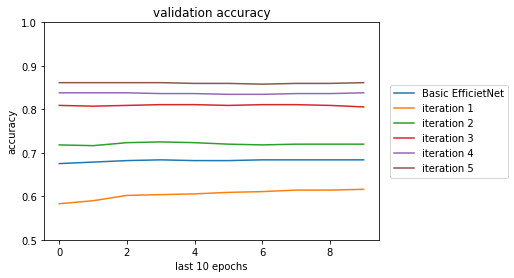

In [30]:
# summarize history for accuracy
plt.plot(hist.history['val_accuracy'])
plt.plot(hist1['val_accuracy'])
plt.plot(hist2['val_accuracy'])
plt.plot(hist3['val_accuracy'])
plt.plot(hist4['val_accuracy'])
plt.plot(hist5['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('last 10 epochs')
plt.ylim(0.5,1)
plt.legend(['Basic EfficietNet','iteration 1','iteration 2','iteration 3','iteration 4','iteration 5'], 
           loc='center right', 
           bbox_to_anchor=(1.4, 0.5))
plt.show()

# Output submission csv for Kaggle


In [34]:
test_ds = test_ds.batch(1)

with open('submission_task2_semisupervised.csv', 'w') as f:
  f.write('id,predicted\n')
  for image_batch, image_names in test_ds:
    predictions = model_list[-1].predict(image_batch)
    for image_name, predictions in zip(image_names.numpy(), model.predict(image_batch)):
      inds = np.argmax(predictions)
      line = str(int(image_name)) + ',' + class_names[inds]
      f.write(line + '\n')

**Note**

Absolute path is recommended here. For example, use "/projectnb2/cs542-bap/[your directory name]/submission_task2_supervised.csv" to replace "submission_task2_supervised.csv".

Besides, you can request good resources by specify the type of gpus, such as "qsub -l gpus=1 -l gpu_type=P100 [your file name].qsub". This is helpful to avoid potential issues of GPUs, such as out of memory, etc.